In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import pandas as pd


In [2]:
data = load_iris()

In [3]:
# Generate synthetic dataset
# X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, 
#                          n_redundant=5, n_classes=3, random_state=42)

X = data.data
y = data.target

In [4]:
X,y

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
        [5

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
class ANN(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], num_classes)
        self.relu = nn.Sigmoid() 
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
verified_model = ANN(input_size=4, hidden_sizes=[64, 32], num_classes=3)

In [8]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(verified_model.parameters(), lr=0.001)

In [9]:
# Training loop
epochs = 30
for epoch in range(epochs):
    verified_model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = verified_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss/len(train_loader):.4f}')

Epoch [5/30], Loss: 1.0716
Epoch [10/30], Loss: 1.0283
Epoch [15/30], Loss: 0.9719
Epoch [20/30], Loss: 0.8858
Epoch [25/30], Loss: 0.7825
Epoch [30/30], Loss: 0.6786


In [10]:
# Evaluation
verified_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = verified_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

verified_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = verified_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Train Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 93.33%
Train Accuracy: 84.17%


In [11]:
activations = {}
def get_activation(name, storage_dict):
    def hook(model, input, output):
        storage_dict[name] = output.detach()
    return hook

verified_model.fc1.register_forward_hook(get_activation('fc1', activations))
verified_model.fc2.register_forward_hook(get_activation('fc2', activations))
verified_model.fc3.register_forward_hook(get_activation('fc3', activations))

In [12]:
calibration_data = X_train[0]

# Get verified activations from original model
verified_model.eval()
with torch.no_grad():
    _ = verified_model(calibration_data)
    target_activations = {k: v.clone() for k, v in activations.items()}

real_activations = target_activations.copy()

# ADVERSARY SETUP INVERSE TRANSFORM

In [13]:
def inverse_transform_reconstruction(target_output, model):
    model.eval()
    
    # Extract model parameters
    W1 = model.fc1.weight.data  # Shape: [64, 4]
    b1 = model.fc1.bias.data    # Shape: [64]
    W2 = model.fc2.weight.data  # Shape: [32, 64]
    b2 = model.fc2.bias.data    # Shape: [32]
    W3 = model.fc3.weight.data  # Shape: [3, 32]
    b3 = model.fc3.bias.data    # Shape: [3]
    
    # Start from the target output and work backwards
    # Step 1: From fc3 output to fc2 output (before ReLU)
    # target_output = W3 @ h2 + b3
    # h2 = W3^+ @ (target_output - b3)  where W3^+ is pseudo-inverse
    
    W3_pinv = torch.pinverse(W3)  # Pseudo-inverse
    h2_before_relu = W3_pinv @ (target_output.squeeze() - b3)
    
    # Apply ReLU constraint (all values should be >= 0 for valid reconstruction)
    h2_after_relu = torch.clamp(h2_before_relu, min=0)
    
    # Step 2: From fc2 output to fc1 output (before ReLU)
    # h2_after_relu = W2 @ h1 + b2
    # h1 = W2^+ @ (h2_after_relu - b2)
    
    W2_pinv = torch.pinverse(W2)
    h1_before_relu = W2_pinv @ (h2_after_relu - b2)
    
    # Apply ReLU constraint
    h1_after_relu = torch.clamp(h1_before_relu, min=0)
    
    # Step 3: From fc1 output to input
    # h1_after_relu = W1 @ x + b1
    # x = W1^+ @ (h1_after_relu - b1)
    
    W1_pinv = torch.pinverse(W1)
    reconstructed_input = W1_pinv @ (h1_after_relu - b1)
    
    return reconstructed_input.unsqueeze(0)  # Add batch dimension

In [ ]:
def inverse_transform_with_constraints(target_output, model, method='least_squares'):
    """
    Enhanced inverse transformation with Sigmoid activation constraints
    """
    model.eval()
    
    # Extract model parameters
    W1 = model.fc1.weight.data
    b1 = model.fc1.bias.data
    W2 = model.fc2.weight.data
    b2 = model.fc2.bias.data
    W3 = model.fc3.weight.data
    b3 = model.fc3.bias.data
    
    if method == 'least_squares':
        # Use pseudo-inverse (least squares solution)
        W3_inv = torch.pinverse(W3)
        h2_before_sigmoid = W3_inv @ (target_output.squeeze() - b3)
        
        # For sigmoid: if h2_after_sigmoid = sigmoid(h2_before_sigmoid)
        # then h2_before_sigmoid = logit(h2_after_sigmoid) = log(h2_after_sigmoid / (1 - h2_after_sigmoid))
        # But we need to work backwards from h2_before_sigmoid to find what h2_after_sigmoid should be
        
        # Apply sigmoid constraint (values should be between 0 and 1)
        h2_after_sigmoid = torch.sigmoid(h2_before_sigmoid)
        
        # Now work backwards: we need h2_before_sigmoid such that sigmoid(W2 @ h1 + b2) = h2_after_sigmoid
        # So: W2 @ h1 + b2 = logit(h2_after_sigmoid)
        h2_logit = torch.logit(torch.clamp(h2_after_sigmoid, 1e-7, 1-1e-7))  # Avoid numerical issues
        
        W2_inv = torch.pinverse(W2)
        h1_before_sigmoid = W2_inv @ (h2_logit - b2)
        h1_after_sigmoid = torch.sigmoid(h1_before_sigmoid)
        
        # Similarly for the first layer
        h1_logit = torch.logit(torch.clamp(h1_after_sigmoid, 1e-7, 1-1e-7))
        
        W1_inv = torch.pinverse(W1)
        x_reconstructed = W1_inv @ (h1_logit - b1)
        
    elif method == 'svd':
        # Use SVD decomposition for more stable inversion
        U3, S3, V3 = torch.svd(W3)
        S3_inv = torch.where(S3 > 1e-6, 1.0/S3, torch.zeros_like(S3))
        W3_inv = V3 @ torch.diag(S3_inv) @ U3.t()
        
        h2_before_sigmoid = W3_inv @ (target_output.squeeze() - b3)
        h2_after_sigmoid = torch.sigmoid(h2_before_sigmoid)
        h2_logit = torch.logit(torch.clamp(h2_after_sigmoid, 1e-7, 1-1e-7))
        
        U2, S2, V2 = torch.svd(W2)
        S2_inv = torch.where(S2 > 1e-6, 1.0/S2, torch.zeros_like(S2))
        W2_inv = V2 @ torch.diag(S2_inv) @ U2.t()
        
        h1_before_sigmoid = W2_inv @ (h2_logit - b2)
        h1_after_sigmoid = torch.sigmoid(h1_before_sigmoid)
        h1_logit = torch.logit(torch.clamp(h1_after_sigmoid, 1e-7, 1-1e-7))
        
        U1, S1, V1 = torch.svd(W1)
        S1_inv = torch.where(S1 > 1e-6, 1.0/S1, torch.zeros_like(S1))
        W1_inv = V1 @ torch.diag(S1_inv) @ U1.t()
        
        x_reconstructed = W1_inv @ (h1_logit - b1)
        
    elif method == 'regularized':
        # Regularized inverse (Ridge regression style)
        lambda_reg = 1e-4
        
        W3_reg_inv = torch.inverse(W3.t() @ W3 + lambda_reg * torch.eye(W3.shape[1])) @ W3.t()
        h2_before_sigmoid = W3_reg_inv @ (target_output.squeeze() - b3)
        h2_after_sigmoid = torch.sigmoid(h2_before_sigmoid)
        h2_logit = torch.logit(torch.clamp(h2_after_sigmoid, 1e-7, 1-1e-7))
        
        W2_reg_inv = torch.inverse(W2.t() @ W2 + lambda_reg * torch.eye(W2.shape[1])) @ W2.t()
        h1_before_sigmoid = W2_reg_inv @ (h2_logit - b2)
        h1_after_sigmoid = torch.sigmoid(h1_before_sigmoid)
        h1_logit = torch.logit(torch.clamp(h1_after_sigmoid, 1e-7, 1-1e-7))
        
        W1_reg_inv = torch.inverse(W1.t() @ W1 + lambda_reg * torch.eye(W1.shape[1])) @ W1.t()
        x_reconstructed = W1_reg_inv @ (h1_logit - b1)
    
    return x_reconstructed.unsqueeze(0)


In [15]:
# Test different inverse transformation methods
methods = ['least_squares', 'svd', 'regularized']
reconstructed_inputs = {}

for method in methods:
    print(f"\nTesting {method} method:")
    try:
        reconstructed_inputs[method] = inverse_transform_with_constraints(
            target_activations['fc3'], verified_model, method=method
        )
        
        # Test the reconstructed input
        activations = {}
        verified_model.fc1.register_forward_hook(get_activation('fc1', activations))
        verified_model.fc2.register_forward_hook(get_activation('fc2', activations))
        verified_model.fc3.register_forward_hook(get_activation('fc3', activations))
        
        with torch.no_grad():
            _ = verified_model(reconstructed_inputs[method])
            reconstructed_activations = {k: v.clone() for k, v in activations.items()}
        
        # Compare activations
        for layer in target_activations.keys():
            abs_diff = torch.abs(target_activations[layer] - reconstructed_activations[layer])
            mean_abs_diff = abs_diff.mean().item()
            max_abs_diff = abs_diff.max().item()
            print(f"  {layer} - Mean: {mean_abs_diff:.6f}, Max: {max_abs_diff:.6f}")
            
    except Exception as e:
        print(f"  Error with {method}: {e}")


Testing least_squares method:
  fc1 - Mean: 0.924042, Max: 2.653619
  fc2 - Mean: 1.189712, Max: 2.630248
  fc3 - Mean: 3.227303, Max: 4.274932

Testing svd method:
  fc1 - Mean: 0.924042, Max: 2.653619
  fc2 - Mean: 1.189712, Max: 2.630248
  fc3 - Mean: 3.227303, Max: 4.274932

Testing regularized method:
  fc1 - Mean: 0.924545, Max: 2.655278
  fc2 - Mean: 1.190483, Max: 2.632172
  fc3 - Mean: 3.229886, Max: 4.278734


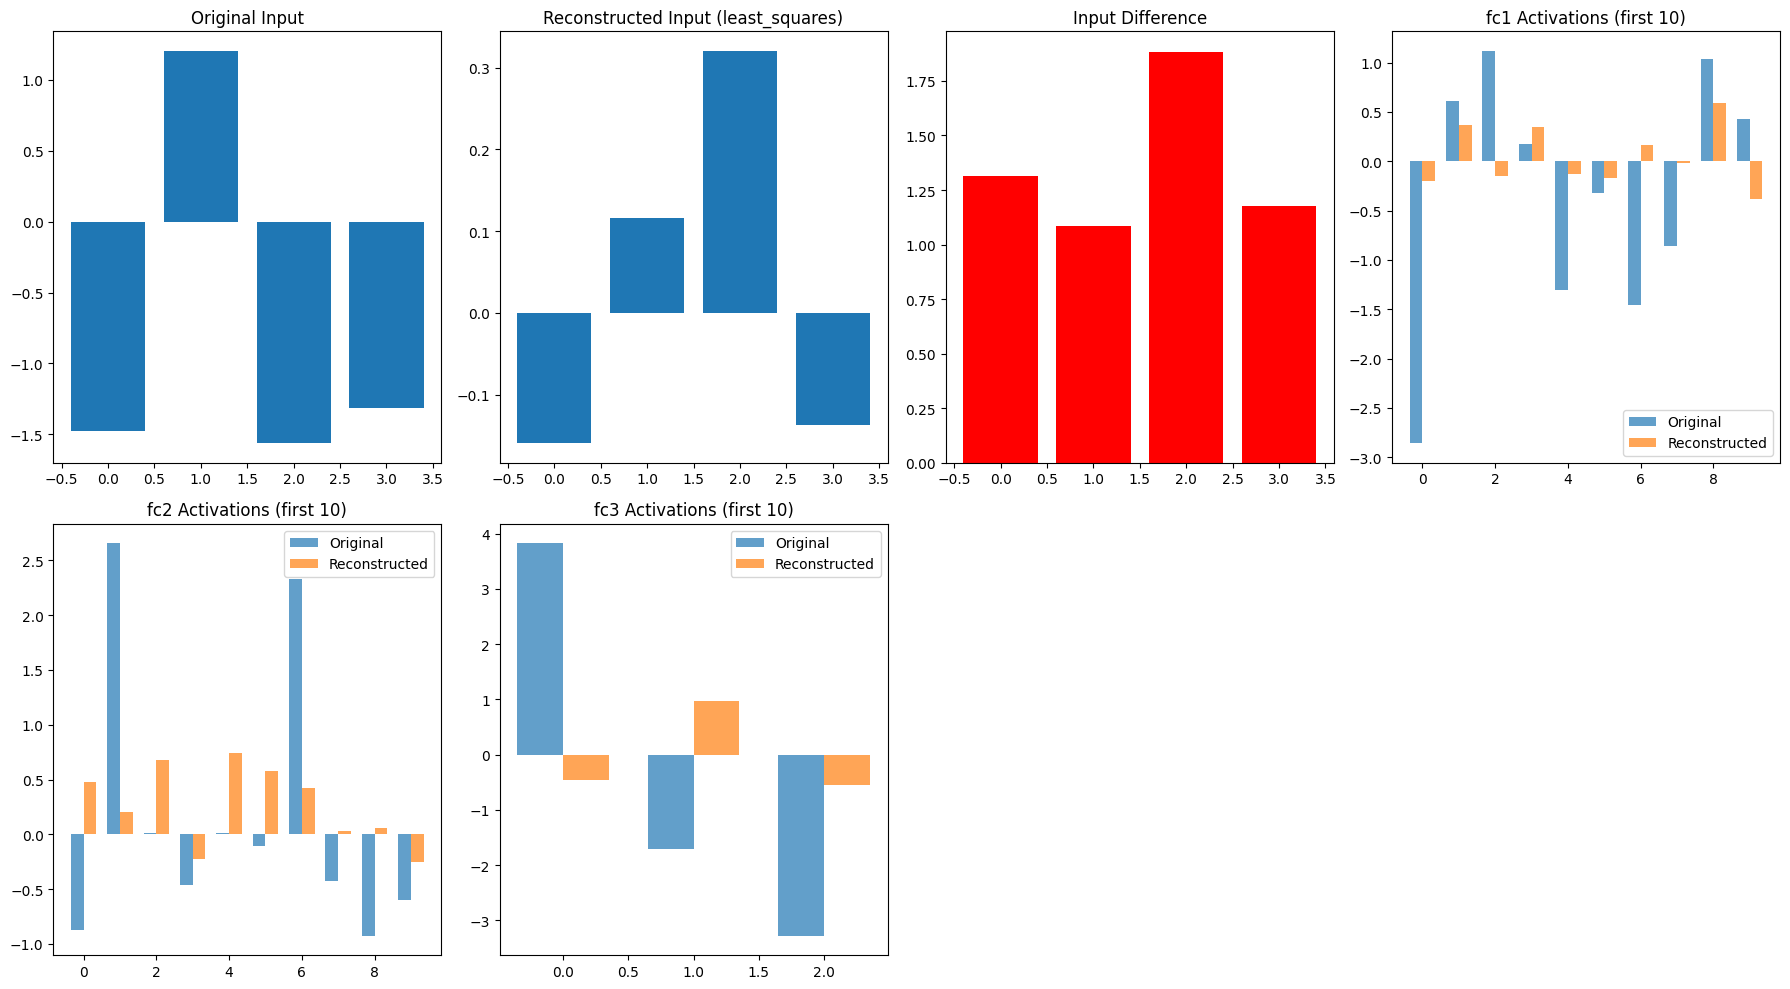


Input reconstruction MAE: 1.364909


In [16]:
best_method = 'least_squares'  # You can change this based on results
if best_method in reconstructed_inputs:
    
    # Get activations for visualization
    activations = {}
    verified_model.fc1.register_forward_hook(get_activation('fc1', activations))
    verified_model.fc2.register_forward_hook(get_activation('fc2', activations))
    verified_model.fc3.register_forward_hook(get_activation('fc3', activations))
    
    with torch.no_grad():
        _ = verified_model(reconstructed_inputs[best_method])
        reconstructed_activations = {k: v.clone() for k, v in activations.items()}
    
    # Plot comparisons
    plt.figure(figsize=(18, 10))
    
    # Compare inputs
    plt.subplot(2, 4, 1)
    plt.title("Original Input")
    plt.bar(range(len(X_train[0])), X_train[0].numpy())
    
    plt.subplot(2, 4, 2)
    plt.title(f"Reconstructed Input ({best_method})")
    plt.bar(range(len(reconstructed_inputs[best_method].flatten())), 
            reconstructed_inputs[best_method].flatten().numpy())
    
    plt.subplot(2, 4, 3)
    plt.title("Input Difference")
    input_diff = torch.abs(X_train[0] - reconstructed_inputs[best_method].flatten())
    plt.bar(range(len(input_diff)), input_diff.numpy(), color='red')
    
    # Compare activations for each layer
    layer_idx = 4
    for layer in ['fc1', 'fc2', 'fc3']:
        plt.subplot(2, 4, layer_idx)
        
        original_act = target_activations[layer].flatten()[:10]  # Show first 10 neurons
        reconstructed_act = reconstructed_activations[layer].flatten()[:10]
        
        x = np.arange(len(original_act))
        width = 0.35
        
        plt.bar(x - width/2, original_act.numpy(), width, label='Original', alpha=0.7)
        plt.bar(x + width/2, reconstructed_act.numpy(), width, label='Reconstructed', alpha=0.7)
        
        plt.title(f'{layer} Activations (first 10)')
        plt.legend()
        layer_idx += 1
    
    plt.tight_layout()
    plt.savefig(f'inverse_transform_comparison_{best_method}.png')
    plt.show()
    
    # Print summary statistics
    input_mae = torch.abs(X_train[0] - reconstructed_inputs[best_method].flatten()).mean().item()
    print(f"\nInput reconstruction MAE: {input_mae:.6f}")

# MULTIPLE INPUT with N ROUND

In [17]:
ROUND = 3
N_INPUTS = 50
results_inverse = pd.DataFrame(columns=[
    'input_id', 'round_id', 'method',
    'fc1_min_abs_diff', 'fc1_max_abs_diff', 'fc1_mean_abs_diff',
    'fc2_min_abs_diff', 'fc2_max_abs_diff', 'fc2_mean_abs_diff',
    'fc3_min_abs_diff', 'fc3_max_abs_diff', 'fc3_mean_abs_diff',
    'input_mae', 'reconstruction_success'
])

methods = ['least_squares', 'svd', 'regularized']

for i in range(N_INPUTS):
    print(f"Input {i+1}")
    
    # Get target activations
    activations = {}
    verified_model.fc1.register_forward_hook(get_activation('fc1', activations))
    verified_model.fc2.register_forward_hook(get_activation('fc2', activations))
    verified_model.fc3.register_forward_hook(get_activation('fc3', activations))
    
    calibration_data = X_train[i]
    verified_model.eval()
    with torch.no_grad():
        _ = verified_model(calibration_data)
        target_activations = {k: v.clone() for k, v in activations.items()}
    
    for j in range(ROUND):
        print(f"  Round {j+1}")
        
        for method in methods:
            try:
                # Reconstruct input using inverse transform
                reconstructed_input = inverse_transform_with_constraints(
                    target_activations['fc3'], verified_model, method=method
                )
                
                # Get activations from reconstructed input
                activations = {}
                verified_model.fc1.register_forward_hook(get_activation('fc1', activations))
                verified_model.fc2.register_forward_hook(get_activation('fc2', activations))
                verified_model.fc3.register_forward_hook(get_activation('fc3', activations))
                
                with torch.no_grad():
                    _ = verified_model(reconstructed_input)
                    reconstructed_activations = {k: v.clone() for k, v in activations.items()}
                
                # Calculate differences
                round_results = {
                    'input_id': i+1, 
                    'round_id': j+1, 
                    'method': method,
                    'reconstruction_success': True
                }
                
                for layer in target_activations.keys():
                    abs_diff = torch.abs(target_activations[layer] - reconstructed_activations[layer])
                    round_results[f'{layer}_min_abs_diff'] = abs_diff.min().item()
                    round_results[f'{layer}_max_abs_diff'] = abs_diff.max().item()
                    round_results[f'{layer}_mean_abs_diff'] = abs_diff.mean().item()
                
                # Input reconstruction error
                input_mae = torch.abs(X_train[i] - reconstructed_input.flatten()).mean().item()
                round_results['input_mae'] = input_mae
                
                results_inverse = pd.concat([results_inverse, pd.DataFrame([round_results])], ignore_index=True)
                
            except Exception as e:
                print(f"    Error with {method}: {e}")
                round_results = {
                    'input_id': i+1, 
                    'round_id': j+1, 
                    'method': method,
                    'reconstruction_success': False,
                    'input_mae': float('inf')
                }
                # Fill other columns with NaN
                for layer in ['fc1', 'fc2', 'fc3']:
                    for metric in ['min_abs_diff', 'max_abs_diff', 'mean_abs_diff']:
                        round_results[f'{layer}_{metric}'] = float('nan')
                
                results_inverse = pd.concat([results_inverse, pd.DataFrame([round_results])], ignore_index=True)

Input 1
  Round 1
  Round 2
  Round 3
Input 2
  Round 1
  Round 2
  Round 3
Input 3
  Round 1
  Round 2
  Round 3
Input 4
  Round 1
  Round 2
  Round 3
Input 5
  Round 1
  Round 2
  Round 3
Input 6
  Round 1
  Round 2
  Round 3
Input 7
  Round 1
  Round 2
  Round 3
Input 8
  Round 1
  Round 2
  Round 3
Input 9
  Round 1


C:\Users\hskay\AppData\Local\Temp\ipykernel_14768\2110728301.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_inverse = pd.concat([results_inverse, pd.DataFrame([round_results])], ignore_index=True)


  Round 2
  Round 3
Input 10
  Round 1
  Round 2
  Round 3
Input 11
  Round 1
  Round 2
  Round 3
Input 12
  Round 1
  Round 2
  Round 3
Input 13
  Round 1
  Round 2
  Round 3
Input 14
  Round 1
  Round 2
  Round 3
Input 15
  Round 1
  Round 2
  Round 3
Input 16
  Round 1
  Round 2
  Round 3
Input 17
  Round 1
  Round 2
  Round 3
Input 18
  Round 1
  Round 2
  Round 3
Input 19
  Round 1
  Round 2
  Round 3
Input 20
  Round 1
  Round 2
  Round 3
Input 21
  Round 1
  Round 2
  Round 3
Input 22
  Round 1
  Round 2
  Round 3
Input 23
  Round 1
  Round 2
  Round 3
Input 24
  Round 1
  Round 2
  Round 3
Input 25
  Round 1
  Round 2
  Round 3
Input 26
  Round 1
  Round 2
  Round 3
Input 27
  Round 1
  Round 2
  Round 3
Input 28
  Round 1
  Round 2
  Round 3
Input 29
  Round 1
  Round 2
  Round 3
Input 30
  Round 1
  Round 2
  Round 3
Input 31
  Round 1
  Round 2
  Round 3
Input 32
  Round 1
  Round 2
  Round 3
Input 33
  Round 1
  Round 2
  Round 3
Input 34
  Round 1
  Round 2
  Round 3
Input

In [ ]:
results_inverse.to_csv('inverse_transform_results.csv', index=False)

In [ ]:
# # %%
# # Analyze and visualize inverse transformation results
# results_inverse = pd.read_csv('inverse_transform_results.csv')

# # Filter successful reconstructions
# successful_results = results_inverse[results_inverse['reconstruction_success'] == True]

# if len(successful_results) > 0:
#     # Compare methods
#     plt.figure(figsize=(20, 12))
    
#     # Plot 1: Input reconstruction error by method
#     plt.subplot(2, 3, 1)
#     sns.boxplot(x='method', y='input_mae', data=successful_results)
#     plt.title('Input Reconstruction Error by Method')
#     plt.yscale('log')
    
#     # Plot 2-4: Layer-wise comparison
#     layers = ['fc1', 'fc2', 'fc3']
#     for idx, layer in enumerate(layers, 2):
#         plt.subplot(2, 3, idx)
#         sns.boxplot(x='method', y=f'{layer}_mean_abs_diff', data=successful_results)
#         plt.title(f'{layer} Mean Absolute Difference')
#         if successful_results[f'{layer}_mean_abs_diff'].max() / successful_results[f'{layer}_mean_abs_diff'].min() > 100:
#             plt.yscale('log')
    
#     # Plot 5: Success rate by method
#     plt.subplot(2, 3, 5)
#     success_rate = results_inverse.groupby('method')['reconstruction_success'].mean()
#     plt.bar(success_rate.index, success_rate.values)
#     plt.title('Reconstruction Success Rate by Method')
#     plt.ylabel('Success Rate')
    
#     # Plot 6: Overall comparison
#     plt.subplot(2, 3, 6)
#     # Calculate overall reconstruction quality (lower is better)
#     successful_results['overall_error'] = (
#         successful_results['input_mae'] + 
#         successful_results['fc1_mean_abs_diff'] + 
#         successful_results['fc2_mean_abs_diff'] + 
#         successful_results['fc3_mean_abs_diff']
#     ) / 4
    
#     sns.boxplot(x='method', y='overall_error', data=successful_results)
#     plt.title('Overall Reconstruction Quality')
#     plt.yscale('log')
    
#     plt.tight_layout()
#     plt.savefig('inverse_transform_analysis.png', bbox_inches='tight')
#     plt.show()
    
#     # Print summary statistics
#     print("\nInverse Transform Method Comparison:")
#     print("="*50)
#     for method in methods:
#         method_data = successful_results[successful_results['method'] == method]
#         if len(method_data) > 0:
#             print(f"\n{method.upper()}:")
#             print(f"  Success Rate: {results_inverse[results_inverse['method'] == method]['reconstruction_success'].mean():.3f}")
#             print(f"  Mean Input MAE: {method_data['input_mae'].mean():.6f}")
#             print(f"  Mean FC3 Diff: {method_data['fc3_mean_abs_diff'].mean():.6f}")
# else:
#     print("No successful reconstructions found!")